# Python Operator
This example shows how to implement and use a custom python operator.

## Defining an operator implementation

In [44]:
import numpy as np

def mix_and_split_channels(image1, image2):
    mixed = (image1 / 255. + image2 / 255.) / 2.
    return mixed[:, :, 0], mixed[:, :, 1], mixed[:, :, 2]

The function above defines a simple operation on RGB images given as numpy arrays. Generally a python operator implementation must be a function that consumes any number of numpy arrays as arguments and produces a numpy array or a tuple of those as an output.

## Example pipeline

In [45]:
from nvidia.dali.pipeline import Pipeline
import nvidia.dali.ops as ops
import nvidia.dali.types as types

image_dir = 'images'

class SimplePipeline(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, _seed, image_dir):
        super(SimplePipeline, self).__init__(batch_size, num_threads, device_id, seed=_seed, exec_async=False,
                                             exec_pipelined=False)
        self.input = ops.FileReader(file_root=image_dir)
        self.decode = ops.HostDecoder(output_type=types.RGB)
        self.flip = ops.Flip()
        self.mix_and_split = ops.PythonFunction(function=mix_and_split_channels, num_outputs=3)

    def load(self):
        jpegs, labels = self.input()
        decoded = self.decode(jpegs)
        return decoded
        
    def define_graph(self):
        images1 = self.load()
        images2 = self.flip(images1)
        r, g, b = self.mix_and_split(images1, images2)
        return r, g, b

Our custom python operator is introduced into pipeline as `PythonFunction`. The function object is passed as a named argument. The number of outputs must be specified on the operator construction level. Default value for `num_outputs` is `1`. Please note that for now custom python operators work only in pipelines with `exec_async=False` and `exec_pipelined=False` specified.

## Running the pipeline and visualizing results

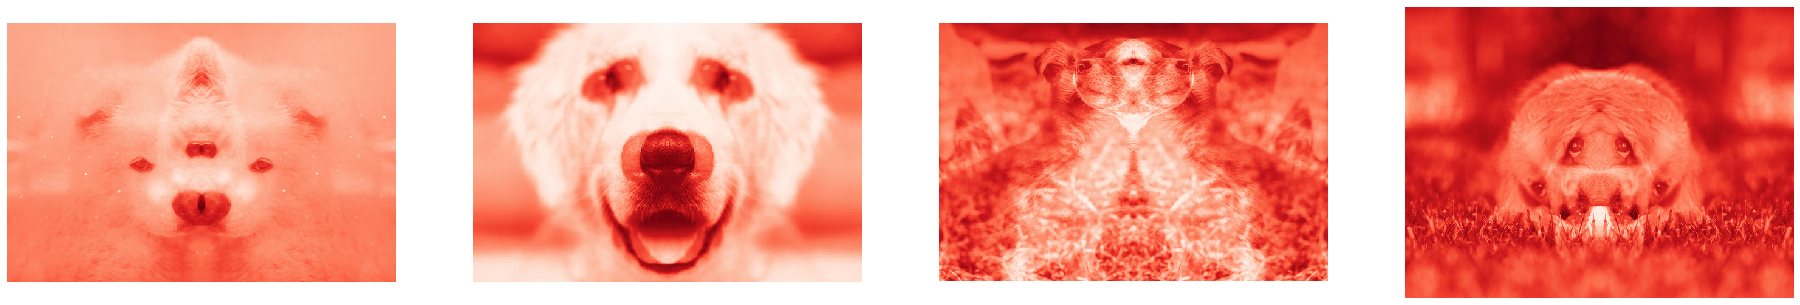

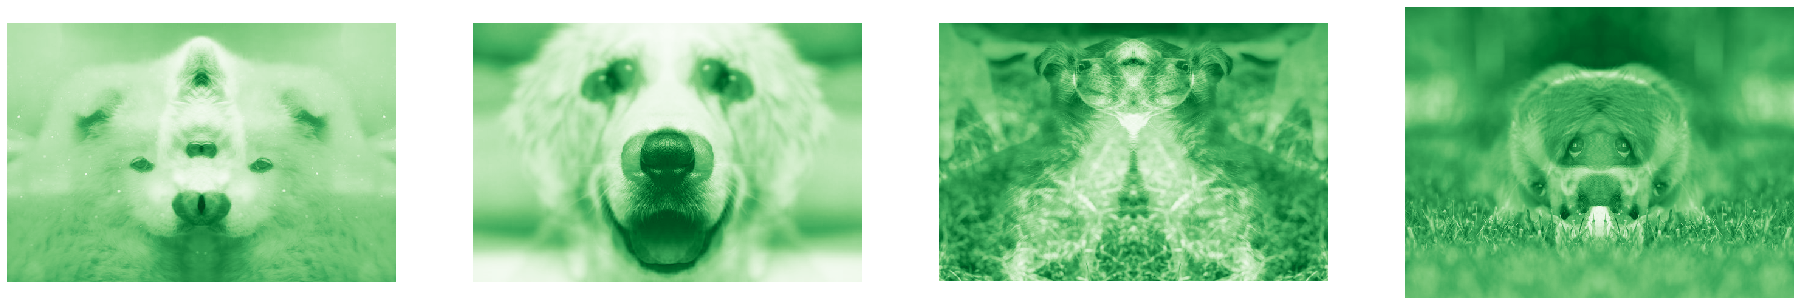

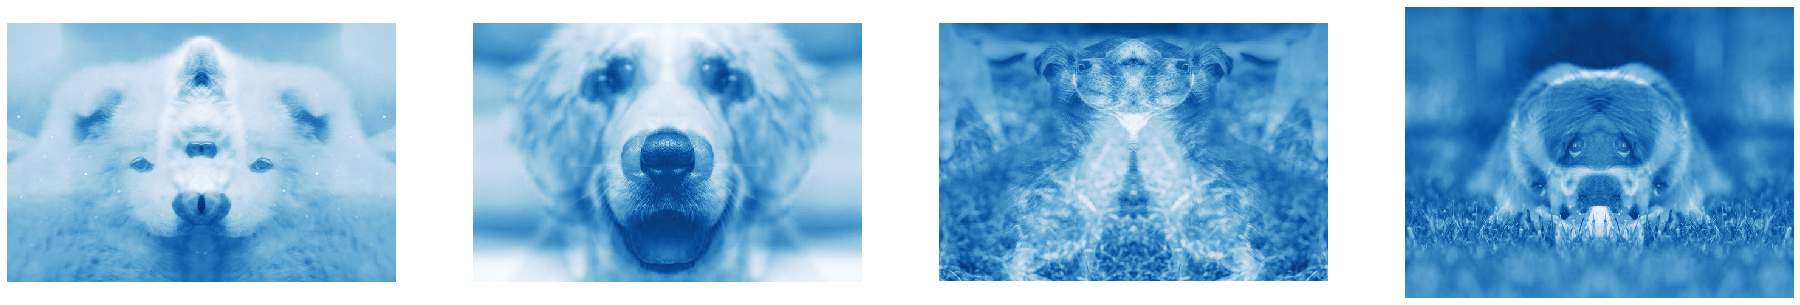

In [50]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm
%matplotlib inline

batch_size = 4

def show_images(image_batch, color_map):
    columns = 4
    rows = (batch_size + 1) // columns
    fig = plt.figure(figsize=(32, (32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows*columns):
        plt.subplot(gs[j])
        plt.axis("off")
        plt.imshow(image_batch.at(j), cmap=plt.get_cmap(color_map))
        
        
pipe = SimplePipeline(batch_size, 4, 0, 12, image_dir)
pipe.build()
r, g, b = pipe.run()

show_images(r, 'Reds_r')
show_images(g, 'Greens_r')
show_images(b, 'Blues_r')